This notebook present the steps to generate merged catalog files. The reason that we need to generate such files is that:

1. Bliss needs input parameters that contains psf, fluxes, location, source type, galaxy related parameters, but the truth catalog in DC2 does not provide galaxy parameters or psf
2. To get those parameter, we need to use CosmoDC2 dataset and truth-match table, where the galaxy parameters and psf are stored.
3. To save the time for multiple merging when loading the data, we store the merged dataset into corresponding merged_catalog_{}.pkl files

### Load Catalog

Use [GCRCatalogs](https://data.lsstdesc.org/doc/install_gcr) package to load the dc2 truth catalog and CosomoDC2.




In [1]:
import pickle
import GCRCatalogs
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from pathlib import Path
import pandas as pd

from GCRCatalogs import GCRQuery

In [2]:
output_dir = Path("./generate_new_catalog_output/")
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
ori_cat = pd.read_pickle("/data/scratch/dc2local/ori_merged_catalog_with_flux_over_50.pkl")

In [4]:
ori_max_ra = ori_cat["ra"].max()
ori_min_ra = ori_cat["ra"].min()
ori_max_dec = ori_cat["dec"].max()
ori_min_dec = ori_cat["dec"].min()
ra_dec_filters = [f"ra >= {ori_min_ra - 0.1}", f"ra <= {ori_max_ra + 0.1}", 
                  f"dec >= {ori_min_dec - 0.1}", f"dec <= {ori_max_dec + 0.1}"]

In [5]:
GCRCatalogs.set_root_dir("/data/scratch/dc2_nfs/")

In [6]:
truth_catalog_pickle_file = output_dir / "truth_catalog.pkl"
if truth_catalog_pickle_file.exists():
    with open(truth_catalog_pickle_file, "rb") as inputp: 
        truth_cat_data = pickle.load(inputp)
else:   
    truth_cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_truth") 
    print(sorted(truth_cat.list_all_quantities()))
    truth_cat_data = truth_cat.get_quantities([
        "id", "match_objectId", "cosmodc2_id", 
        "ra", "dec", 
        "truth_type", 
        "flux_g", "flux_i", "flux_r", "flux_u", "flux_y", "flux_z",
        "redshift",
    ],
    filters=ra_dec_filters)
    # with open(truth_catalog_pickle_file, "wb") as outp:
    #     pickle.dump(truth_cat_data, outp, pickle.HIGHEST_PROTOCOL)

truth_cat_df = pd.DataFrame(truth_cat_data)
truth_cat_df.rename(columns={"redshift": "redshifts"}, inplace=True)

['av', 'cosmodc2_hp', 'cosmodc2_id', 'dec', 'flux_g', 'flux_i', 'flux_r', 'flux_u', 'flux_y', 'flux_z', 'host_galaxy', 'id', 'id_string', 'is_good_match', 'is_nearest_neighbor', 'is_unique_truth_entry', 'mag_g', 'mag_i', 'mag_r', 'mag_u', 'mag_y', 'mag_z', 'match_objectId', 'match_sep', 'patch', 'ra', 'redshift', 'rv', 'tract', 'truth_type']


In [7]:
print(len(truth_cat_df))

60489715


In [8]:
print(1 - (truth_cat_df["flux_r"] > 100).values.sum() / len(truth_cat_df))

0.8513013658602955


In [9]:
print(truth_cat_df["ra"].min(), truth_cat_df["ra"].max())
print(truth_cat_df["dec"].min(), truth_cat_df["dec"].max())

53.80862966850614 61.31827339504263
-38.77768590235156 -34.11487648533201


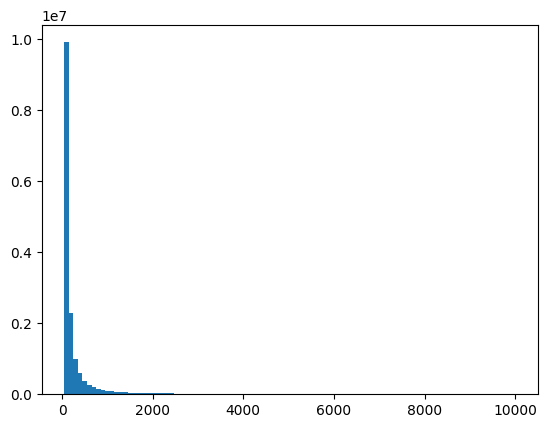

In [10]:
plt.hist(truth_cat_data["flux_r"], np.linspace(50, 10000, num=100))
plt.show()

In [11]:
vertices = hp.ang2vec(np.array([ori_min_ra, ori_max_ra, ori_max_ra, ori_min_ra]),
                      np.array([ori_min_dec, ori_min_dec, ori_max_dec, ori_max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [12]:
cosmodc2_pickle_file = output_dir / "cosmodc2.pkl"
if cosmodc2_pickle_file.exists():
    with open(cosmodc2_pickle_file, "rb") as inputp: 
        cosmodc2_data = pickle.load(inputp)
else:
    config_overwrite = dict(
        catalog_root_dir="/data/scratch/dc2_nfs/cosmoDC2_v1.1.4/"
    )
    cosmodc2_table = GCRCatalogs.load_catalog("desc_cosmodc2", config_overwrite)
    print(sorted(cosmodc2_table.list_all_quantities()))
    cosmodc2_data = cosmodc2_table.get_quantities([
        "galaxy_id",
        "shear_1", "shear_2",
        "ellipticity_1_true_dc2", "ellipticity_2_true_dc2",
        "size_true", "size_minor_true", "position_angle_true_dc2",
    ],
    native_filters=healpix_filter)
    # with open(cosmodc2_pickle_file, "wb") as outp:
    #     pickle.dump(cosmodc2_data, outp, pickle.HIGHEST_PROTOCOL)

cosmodc2_df = pd.DataFrame(cosmodc2_data).rename(columns={
    "ellipticity_1_true_dc2": "ellipticity_1_true",
    "ellipticity_2_true_dc2": "ellipticity_2_true",
})

['A_v', 'A_v_bulge', 'A_v_disk', 'Mag_true_Y_lsst_z0', 'Mag_true_Y_lsst_z0_no_host_extinction', 'Mag_true_g_lsst_z0', 'Mag_true_g_lsst_z0_no_host_extinction', 'Mag_true_g_sdss_z0', 'Mag_true_g_sdss_z0_no_host_extinction', 'Mag_true_i_lsst_z0', 'Mag_true_i_lsst_z0_no_host_extinction', 'Mag_true_i_sdss_z0', 'Mag_true_i_sdss_z0_no_host_extinction', 'Mag_true_r_lsst_z0', 'Mag_true_r_lsst_z0_no_host_extinction', 'Mag_true_r_sdss_z0', 'Mag_true_r_sdss_z0_no_host_extinction', 'Mag_true_u_lsst_z0', 'Mag_true_u_lsst_z0_no_host_extinction', 'Mag_true_u_sdss_z0', 'Mag_true_u_sdss_z0_no_host_extinction', 'Mag_true_y_lsst_z0', 'Mag_true_y_lsst_z0_no_host_extinction', 'Mag_true_z_lsst_z0', 'Mag_true_z_lsst_z0_no_host_extinction', 'Mag_true_z_sdss_z0', 'Mag_true_z_sdss_z0_no_host_extinction', 'R_v', 'R_v_bulge', 'R_v_disk', 'bulge_to_total_ratio_i', 'convergence', 'dec', 'dec_true', 'ellipticity_1_bulge_true', 'ellipticity_1_bulge_true_dc2', 'ellipticity_1_disk_true', 'ellipticity_1_disk_true_dc2', '

In [13]:
print(len(cosmodc2_df))

327021149


In [14]:
print(np.isnan(cosmodc2_df["shear_1"].values).sum() / len(cosmodc2_df))

0.0


In [15]:
cosmodc2_df["shear_1"].describe()

count    3.270211e+08
mean    -2.898190e-03
std      1.803715e-02
min     -1.842399e-01
25%     -1.308544e-02
50%     -2.366003e-03
75%      7.341075e-03
max      1.913079e-01
Name: shear_1, dtype: float64

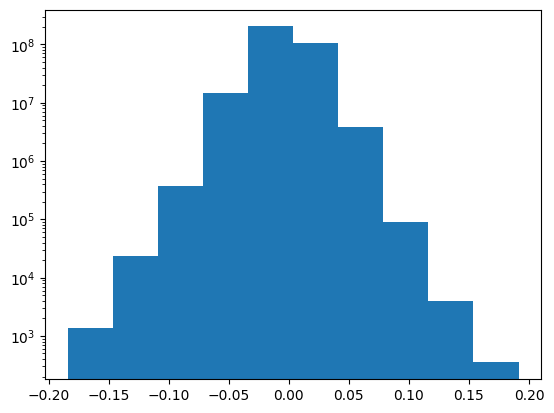

In [16]:
plt.hist(cosmodc2_df["shear_1"], log=True)
plt.show()

In [17]:
print(np.isnan(cosmodc2_df["shear_2"].values).sum() / len(cosmodc2_df))

0.0


In [18]:
cosmodc2_df["shear_2"].describe()

count    3.270211e+08
mean     9.801464e-04
std      1.768306e-02
min     -1.952726e-01
25%     -8.940905e-03
50%      8.083878e-04
75%      1.087075e-02
max      1.886922e-01
Name: shear_2, dtype: float64

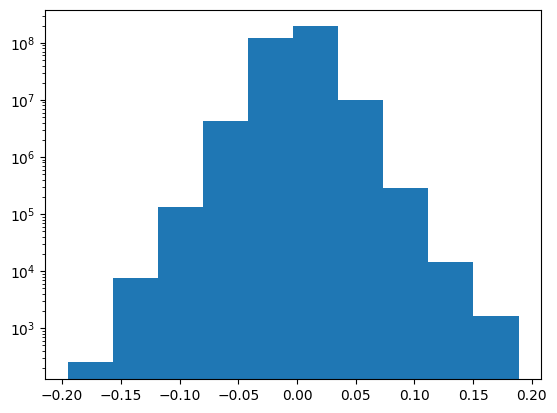

In [19]:
plt.hist(cosmodc2_df["shear_2"], log=True)
plt.show()

In [20]:
print(np.isnan(cosmodc2_df["ellipticity_1_true"].values).sum() / len(cosmodc2_df))

0.0


In [21]:
cosmodc2_df["ellipticity_1_true"].describe()

count    3.270211e+08
mean     2.209228e-05
std      1.571114e-01
min     -9.466370e-01
25%     -3.809191e-02
50%      4.056555e-06
75%      3.816555e-02
max      9.469931e-01
Name: ellipticity_1_true, dtype: float64

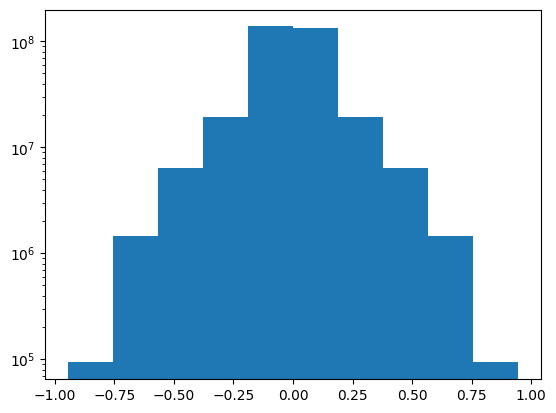

In [22]:
plt.hist(cosmodc2_df["ellipticity_1_true"], log=True)
plt.show()

In [23]:
print(np.isnan(cosmodc2_df["ellipticity_2_true"].values).sum() / len(cosmodc2_df))

0.0


In [24]:
cosmodc2_df["ellipticity_2_true"].describe()

count    3.270211e+08
mean     2.309469e-05
std      1.570970e-01
min     -9.421196e-01
25%     -3.811230e-02
50%     -2.388900e-07
75%      3.814654e-02
max      9.429858e-01
Name: ellipticity_2_true, dtype: float64

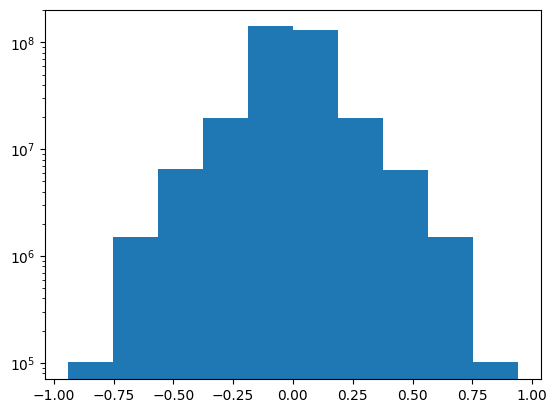

In [25]:
plt.hist(cosmodc2_df["ellipticity_2_true"], log=True)
plt.show()

In [51]:
print(np.isnan(cosmodc2_df["size_true"].values).sum() / len(cosmodc2_df))

0.0


In [26]:
truth_match_pickle_file = output_dir / "psf_params.pkl"
if truth_match_pickle_file.exists():
    with open(truth_match_pickle_file, "rb") as inputp: 
        truth_match_data = pickle.load(inputp)
else:
    truth_match = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    print(sorted(truth_match.list_all_quantities()))
    truth_match_data = truth_match.get_quantities([
        "objectId",
        "blendedness",
        "Ixx_pixel", "Iyy_pixel", "Ixy_pixel",
        "IxxPSF_pixel_g", "IxxPSF_pixel_z", 
        "IxxPSF_pixel_r", "IxxPSF_pixel_i", "IxxPSF_pixel_u", 
        "IxxPSF_pixel_y", "IyyPSF_pixel_g", "IyyPSF_pixel_z", 
        "IyyPSF_pixel_r", "IyyPSF_pixel_i", "IyyPSF_pixel_u", 
        "IyyPSF_pixel_y", "IxyPSF_pixel_g", "IxyPSF_pixel_z", 
        "IxyPSF_pixel_r", "IxyPSF_pixel_i", "IxyPSF_pixel_u", 
        "IxyPSF_pixel_y", "psf_fwhm_g", "psf_fwhm_z", "psf_fwhm_r",
        "psf_fwhm_i", "psf_fwhm_u", "psf_fwhm_y"
    ])
    # with open(truth_match_pickle_file, "wb") as outp:
    #     pickle.dump(truth_match_data, outp, pickle.HIGHEST_PROTOCOL)

truth_match_df = pd.DataFrame(truth_match_data)

['I_flag', 'I_flag_g', 'I_flag_i', 'I_flag_r', 'I_flag_u', 'I_flag_y', 'I_flag_z', 'IxxPSF_pixel', 'IxxPSF_pixel_g', 'IxxPSF_pixel_i', 'IxxPSF_pixel_r', 'IxxPSF_pixel_u', 'IxxPSF_pixel_y', 'IxxPSF_pixel_z', 'Ixx_pixel', 'Ixx_pixel_g', 'Ixx_pixel_i', 'Ixx_pixel_r', 'Ixx_pixel_u', 'Ixx_pixel_y', 'Ixx_pixel_z', 'IxyPSF_pixel', 'IxyPSF_pixel_g', 'IxyPSF_pixel_i', 'IxyPSF_pixel_r', 'IxyPSF_pixel_u', 'IxyPSF_pixel_y', 'IxyPSF_pixel_z', 'Ixy_pixel', 'Ixy_pixel_g', 'Ixy_pixel_i', 'Ixy_pixel_r', 'Ixy_pixel_u', 'Ixy_pixel_y', 'Ixy_pixel_z', 'IyyPSF_pixel', 'IyyPSF_pixel_g', 'IyyPSF_pixel_i', 'IyyPSF_pixel_r', 'IyyPSF_pixel_u', 'IyyPSF_pixel_y', 'IyyPSF_pixel_z', 'Iyy_pixel', 'Iyy_pixel_g', 'Iyy_pixel_i', 'Iyy_pixel_r', 'Iyy_pixel_u', 'Iyy_pixel_y', 'Iyy_pixel_z', 'av_truth', 'blendedness', 'cModelFluxErr_g', 'cModelFluxErr_i', 'cModelFluxErr_r', 'cModelFluxErr_u', 'cModelFluxErr_y', 'cModelFluxErr_z', 'cModelFlux_flag_g', 'cModelFlux_flag_i', 'cModelFlux_flag_r', 'cModelFlux_flag_u', 'cModelFlux

### Merge Catalog 

In [27]:
truth_cat_plus_cosmodc2_df = truth_cat_df.merge(
    cosmodc2_df, 
    left_on="cosmodc2_id", 
    right_on="galaxy_id", 
    how="left" 
)
cosmodc2_mask = ~(np.isnan(truth_cat_plus_cosmodc2_df["ellipticity_1_true"].values) |
                  np.isnan(truth_cat_plus_cosmodc2_df["ellipticity_2_true"].values))
truth_cat_plus_cosmodc2_df["cosmodc2_mask"] = cosmodc2_mask
full_df = truth_cat_plus_cosmodc2_df.merge(
    truth_match_df, 
    left_on="match_objectId", 
    right_on="objectId", 
    how="left" 
)

In [28]:
print(len(truth_cat_df))
print(len(cosmodc2_df))
print(len(truth_match_df))
print(len(full_df))

60489715
327021149
147088478
60489715


In [29]:
for k, v in full_df.items():
    print(f"{k} has {np.isnan(v.values).sum()} nans")

match_objectId has 0 nans
truth_type has 0 nans
ra has 0 nans
flux_u has 0 nans
cosmodc2_id has 0 nans
flux_z has 0 nans
flux_r has 0 nans
dec has 0 nans
flux_y has 0 nans
flux_i has 0 nans
redshifts has 0 nans
id has 0 nans
flux_g has 0 nans
galaxy_id has 381448 nans
size_minor_true has 381448 nans
ellipticity_1_true has 381448 nans
ellipticity_2_true has 381448 nans
position_angle_true_dc2 has 381448 nans
shear_1 has 381448 nans
size_true has 381448 nans
shear_2 has 381448 nans
cosmodc2_mask has 0 nans
IyyPSF_pixel_u has 46308567 nans
IxyPSF_pixel_y has 46308588 nans
Ixy_pixel has 47374599 nans
psf_fwhm_i has 46308493 nans
blendedness has 47374612 nans
Ixx_pixel has 47374599 nans
psf_fwhm_y has 46308588 nans
IxyPSF_pixel_r has 46308471 nans
psf_fwhm_z has 46308541 nans
IxxPSF_pixel_r has 46308471 nans
psf_fwhm_g has 46308486 nans
IxxPSF_pixel_u has 46308567 nans
IxxPSF_pixel_z has 46308541 nans
IxyPSF_pixel_i has 46308493 nans
IyyPSF_pixel_z has 46308541 nans
IyyPSF_pixel_r has 46308

In [52]:
for k, v in full_df.items():
    print(f"{k} has {np.isnan(v.values).sum() / len(full_df) * 100:.2f}% nans")

match_objectId has 0.00% nans
truth_type has 0.00% nans
ra has 0.00% nans
flux_u has 0.00% nans
cosmodc2_id has 0.00% nans
flux_z has 0.00% nans
flux_r has 0.00% nans
dec has 0.00% nans
flux_y has 0.00% nans
flux_i has 0.00% nans
redshifts has 0.00% nans
id has 0.00% nans
flux_g has 0.00% nans
galaxy_id has 1.86% nans
size_minor_true has 1.86% nans
ellipticity_1_true has 1.86% nans
ellipticity_2_true has 1.86% nans
position_angle_true_dc2 has 1.86% nans
shear_1 has 1.86% nans
size_true has 1.86% nans
shear_2 has 1.86% nans
cosmodc2_mask has 0.00% nans
IyyPSF_pixel_u has 24.25% nans
IxyPSF_pixel_y has 24.25% nans
Ixy_pixel has 27.46% nans
psf_fwhm_i has 24.25% nans
blendedness has 27.46% nans
Ixx_pixel has 27.46% nans
psf_fwhm_y has 24.25% nans
IxyPSF_pixel_r has 24.25% nans
psf_fwhm_z has 24.25% nans
IxxPSF_pixel_r has 24.25% nans
psf_fwhm_g has 24.25% nans
IxxPSF_pixel_u has 24.25% nans
IxxPSF_pixel_z has 24.25% nans
IxyPSF_pixel_i has 24.25% nans
IyyPSF_pixel_z has 24.25% nans
IyyPSF

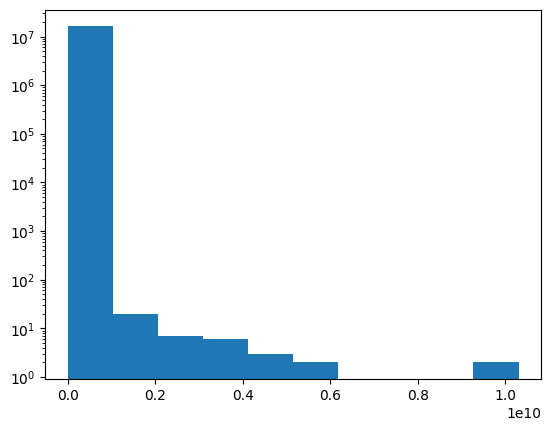

In [30]:
# filter the object by flux
flux_min = 50
full_df = full_df.loc[full_df["flux_r"] > flux_min]
plt.hist(full_df["flux_r"], log=True)
plt.show()

In [31]:
for k, v in full_df.items():
    print(f"{k} has {np.isnan(v.values).sum()} nans")

match_objectId has 0 nans
truth_type has 0 nans
ra has 0 nans
flux_u has 0 nans
cosmodc2_id has 0 nans
flux_z has 0 nans
flux_r has 0 nans
dec has 0 nans
flux_y has 0 nans
flux_i has 0 nans
redshifts has 0 nans
id has 0 nans
flux_g has 0 nans
galaxy_id has 301271 nans
size_minor_true has 301271 nans
ellipticity_1_true has 301271 nans
ellipticity_2_true has 301271 nans
position_angle_true_dc2 has 301271 nans
shear_1 has 301271 nans
size_true has 301271 nans
shear_2 has 301271 nans
cosmodc2_mask has 0 nans
IyyPSF_pixel_u has 3932734 nans
IxyPSF_pixel_y has 3932763 nans
Ixy_pixel has 4454227 nans
psf_fwhm_i has 3932670 nans
blendedness has 4454236 nans
Ixx_pixel has 4454227 nans
psf_fwhm_y has 3932763 nans
IxyPSF_pixel_r has 3932662 nans
psf_fwhm_z has 3932717 nans
IxxPSF_pixel_r has 3932662 nans
psf_fwhm_g has 3932671 nans
IxxPSF_pixel_u has 3932734 nans
IxxPSF_pixel_z has 3932717 nans
IxyPSF_pixel_i has 3932670 nans
IyyPSF_pixel_z has 3932717 nans
IyyPSF_pixel_r has 3932662 nans
IxyPSF_

In [81]:
for k, v in full_df.items():
    print(f"{k} has {np.isnan(v.values).sum() / len(full_df) * 100:.2f}% nans")

match_objectId has 0.00% nans
truth_type has 0.00% nans
ra has 0.00% nans
flux_u has 0.00% nans
cosmodc2_id has 0.00% nans
flux_z has 0.00% nans
flux_r has 0.00% nans
dec has 0.00% nans
flux_y has 0.00% nans
flux_i has 0.00% nans
redshifts has 0.00% nans
id has 0.00% nans
flux_g has 0.00% nans
galaxy_id has 1.86% nans
size_minor_true has 1.86% nans
ellipticity_1_true has 1.86% nans
ellipticity_2_true has 1.86% nans
position_angle_true_dc2 has 1.86% nans
shear_1 has 1.86% nans
size_true has 1.86% nans
shear_2 has 1.86% nans
cosmodc2_mask has 0.00% nans
IyyPSF_pixel_u has 24.25% nans
IxyPSF_pixel_y has 24.25% nans
Ixy_pixel has 27.46% nans
psf_fwhm_i has 24.25% nans
blendedness has 27.46% nans
Ixx_pixel has 27.46% nans
psf_fwhm_y has 24.25% nans
IxyPSF_pixel_r has 24.25% nans
psf_fwhm_z has 24.25% nans
IxxPSF_pixel_r has 24.25% nans
psf_fwhm_g has 24.25% nans
IxxPSF_pixel_u has 24.25% nans
IxxPSF_pixel_z has 24.25% nans
IxyPSF_pixel_i has 24.25% nans
IyyPSF_pixel_z has 24.25% nans
IyyPSF

In [32]:
full_df["flux_r"].describe()

count    1.621836e+07
mean     2.281864e+04
std      5.847398e+06
min      5.000001e+01
25%      7.050085e+01
50%      1.126011e+02
75%      2.485802e+02
max      1.030157e+10
Name: flux_r, dtype: float64

In [33]:
np.quantile(full_df["flux_r"], q=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

array([   50.59747169,    53.13959885,    70.50085068,   112.60108948,
         248.58016968,  1812.32888184, 13139.93003906])

In [34]:
full_df["blendedness"].describe()

count    1.176413e+07
mean     3.977956e-02
std      1.079722e-01
min     -1.678246e+00
25%      0.000000e+00
50%      1.650714e-03
75%      2.591621e-02
max      1.000000e+00
Name: blendedness, dtype: float64

In [35]:
# restrict blendedness
full_df["blendedness"] = np.clip(full_df["blendedness"].values, a_min=0.0, a_max=1.0)

In [36]:
full_df["blendedness"].describe()

count    1.176413e+07
mean     4.021539e-02
std      1.076862e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.650714e-03
75%      2.591621e-02
max      1.000000e+00
Name: blendedness, dtype: float64

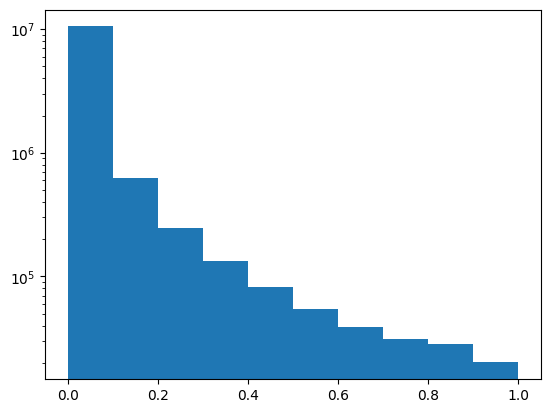

In [37]:
plt.hist(full_df["blendedness"], log=True)
plt.show()

In [38]:
blendedness = full_df["blendedness"].values
np.quantile(blendedness[~np.isnan(blendedness)], q=[0.01, 0.03, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

array([0.        , 0.        , 0.        , 0.        , 0.00165071,
       0.02591621, 0.108194  , 0.21477443, 0.60273517])

In [39]:
full_df["shear_1"].describe()

count    1.591709e+07
mean    -1.878346e-03
std      1.315975e-02
min     -1.465493e-01
25%     -8.145808e-03
50%     -1.236312e-03
75%      4.332724e-03
max      1.379704e-01
Name: shear_1, dtype: float64

In [40]:
full_df["shear_2"].describe()

count    1.591709e+07
mean     8.028432e-04
std      1.310415e-02
min     -1.373055e-01
25%     -5.307656e-03
50%      5.058135e-04
75%      6.926617e-03
max      1.385577e-01
Name: shear_2, dtype: float64

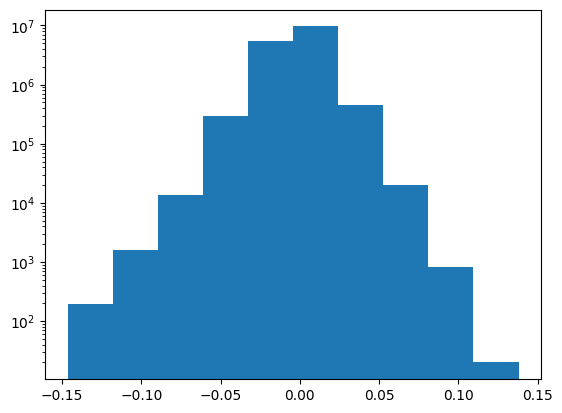

In [41]:
plt.hist(full_df["shear_1"], log=True)
plt.show()

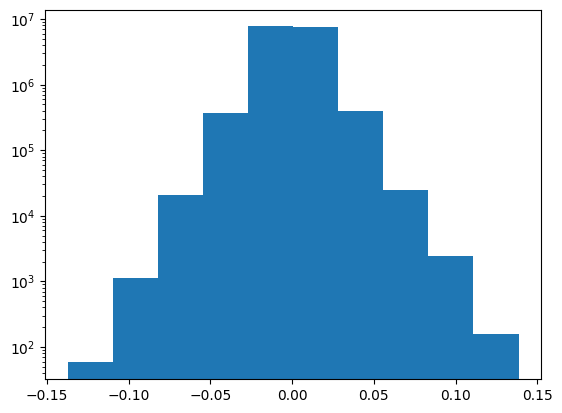

In [42]:
plt.hist(full_df["shear_2"], log=True)
plt.show()

In [43]:
full_df["ellipticity_1_true"].describe()

count    1.591709e+07
mean    -4.294344e-05
std      1.673202e-01
min     -9.198496e-01
25%     -5.190585e-02
50%     -1.147218e-06
75%      5.183802e-02
max      9.345443e-01
Name: ellipticity_1_true, dtype: float64

In [44]:
full_df["ellipticity_2_true"].describe()

count    1.591709e+07
mean     7.575398e-06
std      1.672881e-01
min     -9.260350e-01
25%     -5.182161e-02
50%     -9.414673e-06
75%      5.175925e-02
max      9.182132e-01
Name: ellipticity_2_true, dtype: float64

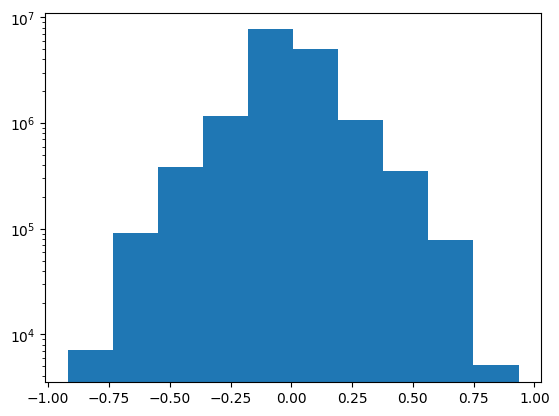

In [45]:
plt.hist(full_df["ellipticity_1_true"], log=True)
plt.show()

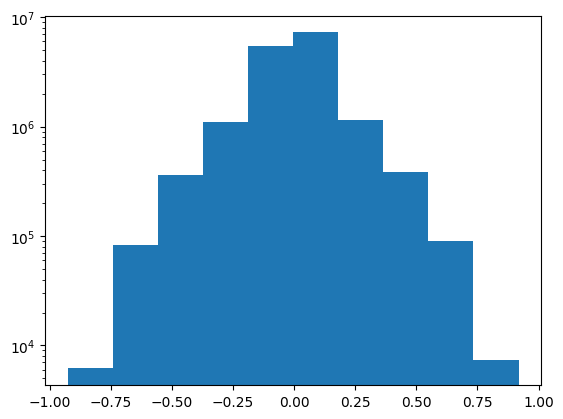

In [46]:
plt.hist(full_df["ellipticity_2_true"], log=True)
plt.show()

In [75]:
sub_full_df = full_df.sample(10000)
sub_full_df_flux_norm = np.linalg.norm(np.stack([sub_full_df[f"flux_{b}"].values for b in "ugrizy"], axis=0), axis=0)
sub_full_df_cosmodc2_mask = sub_full_df["cosmodc2_mask"]

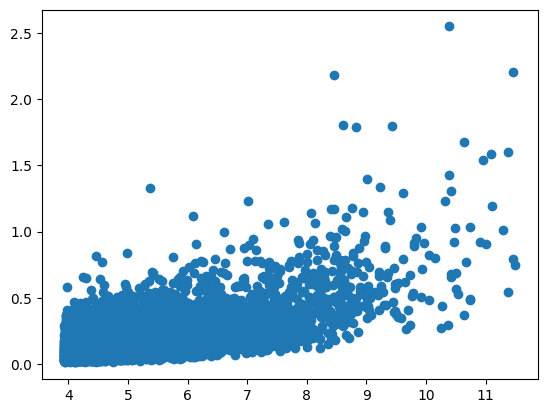

In [76]:
plt.scatter(np.log(sub_full_df["flux_r"] + 1), sub_full_df["size_true"])
plt.show()

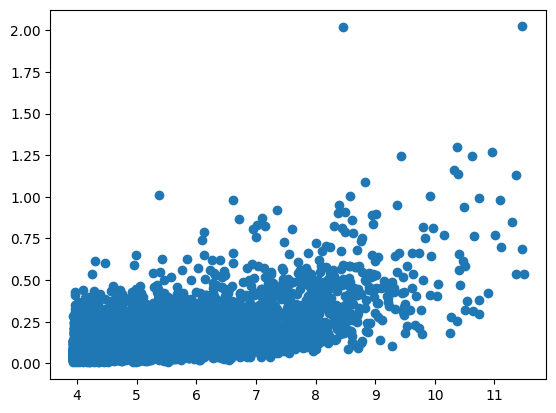

In [82]:
plt.scatter(np.log(sub_full_df["flux_r"] + 1), sub_full_df["size_minor_true"])
plt.show()

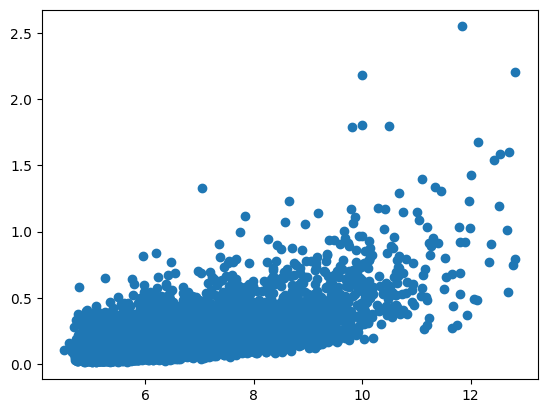

In [77]:
plt.scatter(np.log(sub_full_df_flux_norm + 1), sub_full_df["size_true"])
plt.show()

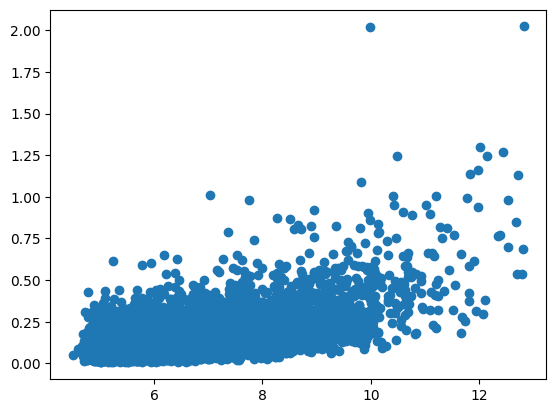

In [83]:
plt.scatter(np.log(sub_full_df_flux_norm + 1), sub_full_df["size_minor_true"])
plt.show()

In [80]:
print(np.array2string(np.corrcoef(sub_full_df["size_true"][sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df["flux_r"][sub_full_df_cosmodc2_mask] + 1)), precision=3))

[[1.   0.63]
 [0.63 1.  ]]


In [79]:
print(np.array2string(np.corrcoef(sub_full_df["size_true"][sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

[[1.    0.656]
 [0.656 1.   ]]


In [84]:
print(np.array2string(np.corrcoef(sub_full_df["size_minor_true"][sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

[[1.    0.622]
 [0.622 1.   ]]


In [89]:
print(np.array2string(np.corrcoef(np.random.randn(sub_full_df_cosmodc2_mask.sum()), 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

[[ 1.    -0.015]
 [-0.015  1.   ]]


In [90]:
sub_full_df_max_size = np.stack([sub_full_df["size_true"].values, 
                                 sub_full_df["size_minor_true"].values], axis=0).max(axis=0)

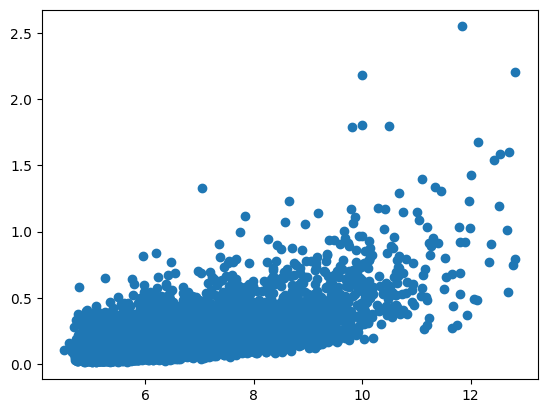

In [101]:
plt.scatter(np.log(sub_full_df_flux_norm + 1), sub_full_df_max_size)
plt.show()

In [97]:
print(np.array2string(np.corrcoef(sub_full_df_max_size[sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

[[1.    0.656]
 [0.656 1.   ]]


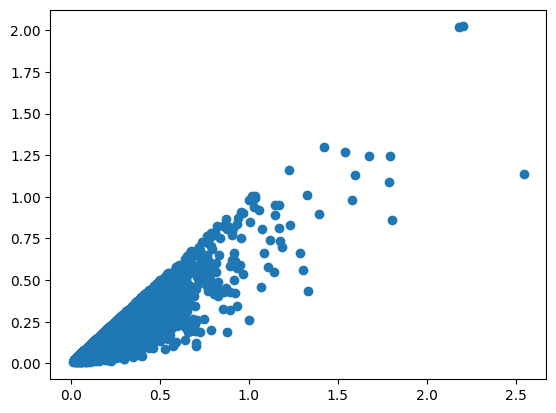

In [99]:
plt.scatter(sub_full_df["size_true"], sub_full_df["size_minor_true"])
plt.show()

In [103]:
sub_full_df_size_sqrt = np.sqrt(sub_full_df["size_true"].values ** 2 + sub_full_df["size_minor_true"].values ** 2)

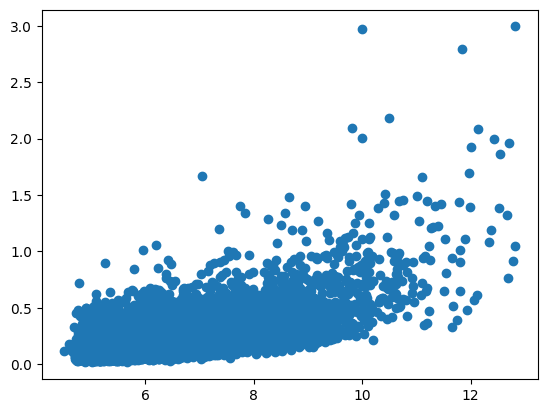

In [104]:
plt.scatter(np.log(sub_full_df_flux_norm + 1), sub_full_df_size_sqrt)
plt.show()

In [105]:
print(np.array2string(np.corrcoef(sub_full_df_size_sqrt[sub_full_df_cosmodc2_mask], 
                                  np.log(sub_full_df_flux_norm[sub_full_df_cosmodc2_mask] + 1)), precision=3))

[[1.   0.66]
 [0.66 1.  ]]


### Save to File

In [47]:
# create a pickle file 
full_df.to_pickle(output_dir / f"merged_catalog_with_flux_over_{flux_min}.pkl")